## Notebook for training for stock price with bunch forecast
Forecast for last 10% of data. Forecast is done in one go.
- Sequential model
- LSTM model
- not stationary
- bunch forecast

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import scipy.stats as si
from IPython.display import Image
import datetime
import time

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from sklearn import preprocessing, metrics

%matplotlib inline

Using TensorFlow backend.


In [3]:
backup = pd.HDFStore('backup_v04.h5')
#df = backup['df']
#unscaled_seq_predictions = backup['unscaled_seq_predictions']
#unscaled_data = backup['unscaled_data']
#unscaled_lstm_predictions = backup['unscaled_lstm_predictions']
#test_data_unscaled = backup['test_data_unscaled']

### Iron Condor
The iron condor is a investment strategy using four option with the same strike date. More precise, the iron condor uses two vertical spreads, one put spread and a call spread. The put spread consists at of a short put option (P_s) with a strike price below the actual stock price and a long put option (P_l) with a strike price below the short put option P_s. The call spread consists of a short call option (C_s) above the actual stock price and a long call option (C_l) above the short call option C_s. All options have the same strike date and the spread on both legs can vary but is chosen mostly the same.
![title](Condor_strategy.png)
"A trader who buys an iron condor speculates that the spot price of the underlying instrument will be between the short strikes when the options expire where the position is the most profitable. Thus, the iron condor is an options strategy considered when the trader has a neutral outlook for the market. Buying iron condors are popular with traders who seek regular income from their trading capital. An iron condor buyer will attempt to construct the trade so that the short strikes are close enough that the position will earn a desirable net credit, but wide enough apart so that it is likely that the spot price of the underlying will remain between the short strikes for the duration of the options contract. The trader would typically play iron condors every month (if possible) thus generating monthly income with the strategy." [https://en.wikipedia.org/wiki/Iron_condor]

### Goal of the project
The goal of the project is to find a strategy to maximise the profit with an iron condor. The ideal short and long spreads should be found at any time based on data of the underlying stock and of the indices S&P500 and Nasdaq

In [3]:
def get_data(var_name,name):
    # reads in csv into DataFrame, keeps Adj Close and Volume and calculates rolling averages and 
    # rolling standard deviation of Adj Close for 4, 9 and 18 days
    # var_name: path to csv file
    # name: name of the column df
    df = pd.read_csv('data/'+var_name+'.csv',index_col='Date', parse_dates=True)
    df.rename(columns={"Adj Close": name, "Volume": name+'_volume', "Open": name+'_open'}, inplace = True)
    df.rename(columns={"High": name+'_high', "Low": name+'_low', "Close": name+'_close'}, inplace = True)
    #df.drop(['Open','High','Low','Close'],axis=1, inplace = True)
    #if name == 'google':
        #df['google_45d'] = df['google'].shift(-32) # stock price in 45 days (approx. 32 trading days)
    df[name+'_ra_04'] = df[name].rolling('4d').mean()
    df[name+'_std_04'] = df[name].rolling('4d').std()
    df[name+'_ra_09'] = df[name].rolling('9d').mean()
    df[name+'_std_09'] = df[name].rolling('9d').std()
    df[name+'_ra_18'] = df[name].rolling('18d').mean()
    df[name+'_std_18'] = df[name].rolling('18d').std()
    return df

In [4]:
def sigma_fct(df, name, days = 10):
    # For Black-Scholes I need the volatility of return of the underlying assets in the last days
    # based on https://www.wikihow.com/Calculate-Historical-Stock-Volatility
    # First the ln of daily returns is calculated for each element of names
    for name in names:
        a=pd.DataFrame()
        a['ln_daily_return'] = np.log(df[name] / df[name].shift(1))
        # next the rolling average (mean) over certain days is calculated
        a['rol_avg'] =  a['ln_daily_return'].rolling(str(days)+'d').mean()
        # next deviation from the mean is calculated
        a['dev_mean'] = a['ln_daily_return'] - a['rol_avg']
        # next variance is calculated for certain days
        a['dev_mean_sq'] = a['dev_mean']**2
        a['variance'] = a['dev_mean_sq'].rolling(str(days)+'d').sum()/(a['dev_mean_sq'].rolling(str(days)+'d').count()-1)
        # volatility is square root of variance
        # do you need annual volatility?
        df[name + '_daily_vol'] = np.sqrt(a['variance'])*np.sqrt(252) # 252 trading days in a year
        #df.drop(['ln_daily_return'])#,'rol_avg','dev_mean','dev_mean_sq','variance'])
        #return df[name + '_daily_vol']
    return df

In [5]:
def stationary_timeseries(df, damned_list = ['volume','std','short','daily']):
    # makes columns in df that are not in damned list stationary. Means it calculates the 
    # difference row by row
    columns = df.columns
    df_sta = pd.DataFrame()
    for column in columns:
        if any(elem in column for elem in damned_list):
            df_sta[column] = df[column]
        else:
            df_sta[column+'_sta'] = df[column] - df[column].shift(1)
    df_sta.dropna(inplace = True)  # to make sure we have all the data on all the days
    return df_sta

In [6]:
def get_df(var_name_list,name_list):
    # takes list paths of csv files and names and passes it on to get_data.
    # Gets df from get_data and merges them on 'Date'
    # Calls sigma_fct to get sigma of daily returns 
    # var_name_list: list of paths to csv files
    # name: list of names the columns of df
    i=0
    for var_name in var_name_list:
        if i == 0:
            df = get_data(var_name, name_list[i])
        else:
            df = pd.merge(df,get_data(var_name, name_list[i]),on='Date')
        i += 1
    df.dropna(inplace = True)  # to make sure we have all the data on all the days
    
    df = sigma_fct(df,names)
    df=df[23:] # drop first entries to get clean results

    return df

In [7]:
def get_target_data(df, name):
    # function to create the target data
    # name: name of the column the target data is created of
    df[name+'_45d'] = df[name].shift(-32) # stock price in 45 days (approx. 32 trading days)
    df.dropna(inplace = True)  # to make sure we have all the data on all the days
    # df['short_call'] shows the perfect short call. If you would have shorted a call option with a strike price 
    # exactly the same as the stock price 45 days later, you made maximum profit. Therefore this is the target 
    # value for the short call option. The minimum is 0, so we never short a call option with a strike price
    # below the stock price right now. The same for the short put option
    #df['short_call'] = [x/y-1 if x/y > 1 else 0 for x,y in df[[name+'_45d', name]].values]
    #df['short_put'] = [1-x/y if x/y < 1 else 0 for x,y in df[[name+'_45d', name]].values]
    return df

In [8]:
var_names = ['GOOG','S&P','Nasdaq2']
names = ['google','s&p','nasdaq']
df = get_df(var_names, names)
df = get_target_data(df, 'google')
df.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_04,nasdaq_std_04,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-21,130.764862,134.182053,123.188263,130.725006,130.725006,20565700,136.935478,8.750923,143.875715,10.798013,...,1392.540009,68.742234,1452.251430,95.188063,1541.462141,127.530682,0.716470,0.802275,0.738519,156.946732
2008-11-24,134.127258,134.470963,124.040070,128.239334,128.239334,20184700,129.482170,1.757636,137.580147,9.599201,...,1428.184998,61.992083,1420.705017,68.914436,1498.502503,101.345711,0.529842,0.864400,0.777819,155.761169
2008-11-25,133.838348,142.794769,133.160873,140.498383,140.498383,21623100,134.368858,8.668457,137.997038,8.831976,...,1468.375000,5.154837,1426.994298,65.073432,1483.279999,90.035297,0.833833,0.791313,0.710049,156.573120
2008-11-26,139.616684,147.178345,137.584305,145.499634,145.499634,12760800,138.079117,8.880829,137.425609,8.059325,...,1489.616659,36.971751,1434.144287,74.235572,1487.035382,87.259170,0.812863,0.758392,0.707779,149.923050
2008-11-28,144.747452,147.671494,143.601746,145.933014,145.933014,5150200,143.977010,3.020363,136.698456,8.236770,...,1510.799967,39.935485,1450.814982,86.016593,1480.791532,79.789023,0.871477,0.804582,0.756923,148.936752


In [10]:
backup['df'] = df

### Price of options
It is really hard to get data about historic stock options. Be it as api channel or csv download. I managed only to find sources to pay: 500 USD for every year. Because that is too expensive for this project I decided to calculate the option price with the **Black–Scholes formula**, which gives a theoretical estimate of the price of European-style options.

Based on the formula for non-divident paying options I calculate the option prices and add a small random term to create a bit of noise.

In [11]:
def black_scholes(S, K, sigma, r=0.03, T=45/365, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity in years, 45 days as default
    #r: risk-free interest rate, assumed to be constant between t and T
    #sigma: standard deviation (volatility) of RETURNS of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    #d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [12]:
def option_prices(date, short_spread, long_spread, strike_days = 45):
    # calculates prices of options and calculates initial return (net premium)
    date = date_fct(date)
    P_s_strike_price, P_l_strike_price, C_s_strike_price, C_l_strike_price = strike_prices(date, short_spread, long_spread)
    sigma = get_sigma(date)
    stock_price = stock_price_fct(date)
    P_s_price = black_scholes(stock_price, P_s_strike_price, sigma, T=strike_days/365, option = 'put')
    P_l_price = black_scholes(stock_price, P_l_strike_price, sigma, T=strike_days/365, option = 'put')
    C_s_price = black_scholes(stock_price, C_s_strike_price, sigma, T=strike_days/365, option = 'call')
    C_l_price = black_scholes(stock_price, C_l_strike_price, sigma, T=strike_days/365, option = 'call')
    initial_return = P_s_price + C_s_price - P_l_price - C_l_price
    
    return P_s_price, P_l_price, C_s_price, C_l_price, initial_return

Now it is time to calculate the strike prices and option prices of all 4 options and the initial return by setting up the iron condor

### Calculate return of options
There are five different regimes for the return. R: return, P(C) put(call) option, s(l): short(long), ir: initial return, stock_price: stock price
- stock price is below long put option: R = ir + P_l_strike_price - P_s_strike_price
- stock price is between long and short put option: R = ir + stock_price - P_s_strike_price
- stock price is between short call and short put option: R = ir
- stock price is between short and long call option: R = ir - stock_price + C_s_strike price
- stock price is above long call option: R = ir - C_l_strike_price + C_s_strike_price

#### Define return function of iron condor

In [13]:
def ic_return(trading_date, short_spread, long_spread, strike_days = 45):
    P_s_strike_price, P_l_strike_price, C_s_strike_price, C_l_strike_price = strike_prices(trading_date, short_spread, long_spread)
    P_s_price, P_l_price, C_s_price, C_l_price, initial_return = option_prices(trading_date,short_spread, long_spread, strike_days)
    strike_date = date_fct(trading_date, 45)
    final_stock_price = stock_price_fct(strike_date)
    if final_stock_price < P_l_strike_price:
        final_result = initial_return + P_l_strike_price - P_s_strike_price
    elif final_stock_price >= P_l_strike_price and final_stock_price < P_s_strike_price:
        final_result = initial_return + stock_price - P_s_strike_price
    elif final_stock_price >= P_s_strike_price and final_stock_price < C_s_strike_price:
        final_result = initial_return
    elif final_stock_price >= C_s_strike_price and final_stock_price < C_l_strike_price:
        final_result = initial_return - final_stock_price + C_s_strike_price
    elif final_stock_price >= C_l_strike_price:
        final_result = initial_return - C_l_strike_price + C_s_strike_price
    maximum_result = initial_return
    return final_result

### Building the model

#### Scale data

In [14]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index = df.index)

/home/matthias/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Split into train and test set

In [49]:
def get_train_test_data(data, train_test_split, batch_size):
    # data is dataframe to get train test data out of
    train_size_raw = data.shape[0]*train_test_split
    train_size = int(train_size_raw - train_size_raw % batch_size) # make train_size multiple of batch_size for "statefull = True" in LSTM
    train_data = data.iloc[0:train_size]
    test_size_raw = data.shape[0] - train_size
    test_size = int(test_size_raw - test_size_raw%batch_size) # multiple of batch_size
    test_data = data.iloc[train_size : train_size + test_size]
    x_train = train_data.drop(columns=['google_45d']) # google_45d is not for training, just for reversing stationarity
    y_train = train_data['google_45d']
    x_test = test_data.drop(columns=['google_45d'])
    y_test = test_data['google_45d']
    train_index=x_train.index
    x_columns = x_train.columns
    test_index = x_test.index
    return x_train, x_test, y_train, y_test, test_data, test_index, x_columns

In [50]:
batch_size = 10
train_test_split = 0.9
x_train, x_test, y_train, y_test, test_data, test_index, x_columns = get_train_test_data(df_scaled, train_test_split, batch_size)

### Sequential model

In [51]:
# Build the model architecture
seq_model = Sequential()
seq_model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(16, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(4, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(1))

# Compile the model using a loss function and an optimizer.
seq_model.compile(optimizer='adam',loss='mean_squared_error')
seq_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               5120      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_6 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total para

In [52]:
start_seq = time.time()
seq_history=seq_model.fit(x_train, y_train, epochs=3000, batch_size=50, verbose=1, validation_data=(x_test, y_test));
end_seq = time.time()
time_seq = end_seq - start_seq
time_seq

Train on 2370 samples, validate on 270 samples
Epoch 1/3000
2370/2370 [==============================] - 1s 310us/step - loss: 0.1499 - val_loss: 0.3492
Epoch 2/3000
2370/2370 [==============================] - 0s 55us/step - loss: 0.0909 - val_loss: 0.0729
Epoch 3/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0749 - val_loss: 0.0651
Epoch 4/3000
2370/2370 [==============================] - 0s 126us/step - loss: 0.0659 - val_loss: 0.0650
Epoch 5/3000
2370/2370 [==============================] - 0s 120us/step - loss: 0.0663 - val_loss: 0.0630
Epoch 6/3000
2370/2370 [==============================] - 0s 98us/step - loss: 0.0582 - val_loss: 0.0543
Epoch 7/3000
2370/2370 [==============================] - 0s 57us/step - loss: 0.0570 - val_loss: 0.0499
Epoch 8/3000
2370/2370 [==============================] - 0s 124us/step - loss: 0.0546 - val_loss: 0.0423
Epoch 9/3000
2370/2370 [==============================] - 0s 111us/step - loss: 0.0496 - val_loss: 0.0682
Epo

Epoch 78/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0389 - val_loss: 0.0398
Epoch 79/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0408 - val_loss: 0.0501
Epoch 80/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0407 - val_loss: 0.0338
Epoch 81/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0414 - val_loss: 0.0340
Epoch 82/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0403 - val_loss: 0.0387
Epoch 83/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0389 - val_loss: 0.0374
Epoch 84/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0388 - val_loss: 0.0394
Epoch 85/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0397 - val_loss: 0.0666
Epoch 86/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0411 - val_loss: 0.0418
Epoch 87/3000
2370/2370 [=====================

Epoch 155/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0363 - val_loss: 0.0467
Epoch 156/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0374 - val_loss: 0.0446
Epoch 157/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0371 - val_loss: 0.0392
Epoch 158/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0384 - val_loss: 0.0448
Epoch 159/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0409 - val_loss: 0.0466
Epoch 160/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0399 - val_loss: 0.0455
Epoch 161/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0379 - val_loss: 0.0346
Epoch 162/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0397 - val_loss: 0.0453
Epoch 163/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0382 - val_loss: 0.0688
Epoch 164/3000
2370/2370 [===========

2370/2370 [==============================] - 0s 30us/step - loss: 0.0400 - val_loss: 0.0445
Epoch 308/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0361 - val_loss: 0.0495
Epoch 309/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0345 - val_loss: 0.0457
Epoch 310/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0350 - val_loss: 0.0340
Epoch 311/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0358 - val_loss: 0.0667
Epoch 312/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0368 - val_loss: 0.0383
Epoch 313/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0382 - val_loss: 0.0407
Epoch 314/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0368 - val_loss: 0.0571
Epoch 315/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0349 - val_loss: 0.0405
Epoch 316/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 30us/step - loss: 0.0404 - val_loss: 0.0547
Epoch 460/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0343 - val_loss: 0.0487
Epoch 461/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0321 - val_loss: 0.0495
Epoch 462/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0341 - val_loss: 0.0566
Epoch 463/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0350 - val_loss: 0.0406
Epoch 464/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0344 - val_loss: 0.0436
Epoch 465/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0376 - val_loss: 0.0527
Epoch 466/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0349 - val_loss: 0.0328
Epoch 467/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0351 - val_loss: 0.0483
Epoch 468/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 29us/step - loss: 0.0341 - val_loss: 0.0542
Epoch 612/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0374 - val_loss: 0.0479
Epoch 613/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0358 - val_loss: 0.0598
Epoch 614/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0362 - val_loss: 0.0510
Epoch 615/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0394 - val_loss: 0.0372
Epoch 616/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0350 - val_loss: 0.0390
Epoch 617/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0345 - val_loss: 0.0645
Epoch 618/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0353 - val_loss: 0.0506
Epoch 619/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0349 - val_loss: 0.0485
Epoch 620/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 32us/step - loss: 0.0345 - val_loss: 0.0543
Epoch 764/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0327 - val_loss: 0.0396
Epoch 765/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0347 - val_loss: 0.0561
Epoch 766/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0345 - val_loss: 0.0462
Epoch 767/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0360 - val_loss: 0.0385
Epoch 768/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0369 - val_loss: 0.0431
Epoch 769/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0360 - val_loss: 0.0748
Epoch 770/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0352 - val_loss: 0.0538
Epoch 771/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0346 - val_loss: 0.0693
Epoch 772/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 30us/step - loss: 0.0359 - val_loss: 0.0419
Epoch 916/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0356 - val_loss: 0.0509
Epoch 917/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0362 - val_loss: 0.0549
Epoch 918/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0358 - val_loss: 0.0532
Epoch 919/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0362 - val_loss: 0.0550
Epoch 920/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0370 - val_loss: 0.0511
Epoch 921/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0398 - val_loss: 0.0474
Epoch 922/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0400 - val_loss: 0.0421
Epoch 923/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0385 - val_loss: 0.0434
Epoch 924/3000
2370/2370 [==========================

2370/2370 [==============================] - 0s 29us/step - loss: 0.0364 - val_loss: 0.0439
Epoch 1068/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0341 - val_loss: 0.0543
Epoch 1069/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0344 - val_loss: 0.0612
Epoch 1070/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0337 - val_loss: 0.0525
Epoch 1071/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0356 - val_loss: 0.0503
Epoch 1072/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0397 - val_loss: 0.0444
Epoch 1073/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0350 - val_loss: 0.0475
Epoch 1074/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0345 - val_loss: 0.0350
Epoch 1075/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0332 - val_loss: 0.0454
Epoch 1076/3000
2370/2370 [=================

2370/2370 [==============================] - 0s 31us/step - loss: 0.0355 - val_loss: 0.0408
Epoch 1144/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0328 - val_loss: 0.0437
Epoch 1145/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0337 - val_loss: 0.0469
Epoch 1146/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0341 - val_loss: 0.0594
Epoch 1147/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0375 - val_loss: 0.0464
Epoch 1148/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0384 - val_loss: 0.0469
Epoch 1149/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0354 - val_loss: 0.0462
Epoch 1150/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0404 - val_loss: 0.0443
Epoch 1151/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0339 - val_loss: 0.0589
Epoch 1152/3000
2370/2370 [=================

2370/2370 [==============================] - 0s 31us/step - loss: 0.0419 - val_loss: 0.0619
Epoch 1220/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0357 - val_loss: 0.0453
Epoch 1221/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0376 - val_loss: 0.0437
Epoch 1222/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0335 - val_loss: 0.0478
Epoch 1223/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0363 - val_loss: 0.0366
Epoch 1224/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0364 - val_loss: 0.0372
Epoch 1225/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0322 - val_loss: 0.0420
Epoch 1226/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0358 - val_loss: 0.0545
Epoch 1227/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0367 - val_loss: 0.0745
Epoch 1228/3000
2370/2370 [=================

2370/2370 [==============================] - 0s 29us/step - loss: 0.0370 - val_loss: 0.0575
Epoch 1296/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0403 - val_loss: 0.0361
Epoch 1297/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0353 - val_loss: 0.0516
Epoch 1298/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0337 - val_loss: 0.0429
Epoch 1299/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0359 - val_loss: 0.0494
Epoch 1300/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0341 - val_loss: 0.0710
Epoch 1301/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0345 - val_loss: 0.0417
Epoch 1302/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0351 - val_loss: 0.0367
Epoch 1303/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0356 - val_loss: 0.0418
Epoch 1304/3000
2370/2370 [=================

2370/2370 [==============================] - 0s 77us/step - loss: 0.0337 - val_loss: 0.0449
Epoch 1372/3000
2370/2370 [==============================] - 0s 75us/step - loss: 0.0343 - val_loss: 0.0533
Epoch 1373/3000
2370/2370 [==============================] - 0s 58us/step - loss: 0.0325 - val_loss: 0.0469
Epoch 1374/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0339 - val_loss: 0.0386
Epoch 1375/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0345 - val_loss: 0.0459
Epoch 1376/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0356 - val_loss: 0.0522
Epoch 1377/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0372 - val_loss: 0.0622
Epoch 1378/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0347 - val_loss: 0.0509
Epoch 1379/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0361 - val_loss: 0.0466
Epoch 1380/3000
2370/2370 [=================

Epoch 1447/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0370 - val_loss: 0.0449
Epoch 1448/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0341 - val_loss: 0.0465
Epoch 1449/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0363 - val_loss: 0.0548
Epoch 1450/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0385 - val_loss: 0.0452
Epoch 1451/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0338 - val_loss: 0.0494
Epoch 1452/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0351 - val_loss: 0.0499
Epoch 1453/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0367 - val_loss: 0.0459
Epoch 1454/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0336 - val_loss: 0.0449
Epoch 1455/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0374 - val_loss: 0.0446
Epoch 1456/3000
2370/2370 [=

Epoch 1523/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0375 - val_loss: 0.0545
Epoch 1524/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0338 - val_loss: 0.0579
Epoch 1525/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0396 - val_loss: 0.0366
Epoch 1526/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0338 - val_loss: 0.0570
Epoch 1527/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0345 - val_loss: 0.0501
Epoch 1528/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0353 - val_loss: 0.0507
Epoch 1529/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0348 - val_loss: 0.0420
Epoch 1530/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0372 - val_loss: 0.0549
Epoch 1531/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0393 - val_loss: 0.0619
Epoch 1532/3000
2370/2370 [=

Epoch 1599/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0354 - val_loss: 0.0558
Epoch 1600/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0335 - val_loss: 0.0706
Epoch 1601/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0386 - val_loss: 0.0311
Epoch 1602/3000
2370/2370 [==============================] - 0s 81us/step - loss: 0.0332 - val_loss: 0.0510
Epoch 1603/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0353 - val_loss: 0.0592
Epoch 1604/3000
2370/2370 [==============================] - 0s 34us/step - loss: 0.0349 - val_loss: 0.0472
Epoch 1605/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0341 - val_loss: 0.0548
Epoch 1606/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0349 - val_loss: 0.0438
Epoch 1607/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0366 - val_loss: 0.0505
Epoch 1608/3000
2370/2370 [=

Epoch 1675/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0351 - val_loss: 0.0565
Epoch 1676/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0351 - val_loss: 0.0547
Epoch 1677/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0350 - val_loss: 0.0592
Epoch 1678/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0369 - val_loss: 0.0514
Epoch 1679/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0380 - val_loss: 0.0417
Epoch 1680/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0369 - val_loss: 0.0528
Epoch 1681/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0375 - val_loss: 0.0581
Epoch 1682/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0349 - val_loss: 0.0362
Epoch 1683/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0391 - val_loss: 0.0359
Epoch 1684/3000
2370/2370 [=

Epoch 1751/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0372 - val_loss: 0.0575
Epoch 1752/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0343 - val_loss: 0.0451
Epoch 1753/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0372 - val_loss: 0.0820
Epoch 1754/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0344 - val_loss: 0.0530
Epoch 1755/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0376 - val_loss: 0.0531
Epoch 1756/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0381 - val_loss: 0.0492
Epoch 1757/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0358 - val_loss: 0.0501
Epoch 1758/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0372 - val_loss: 0.0785
Epoch 1759/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0373 - val_loss: 0.0444
Epoch 1760/3000
2370/2370 [=

Epoch 1827/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0345 - val_loss: 0.0461
Epoch 1828/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0349 - val_loss: 0.0671
Epoch 1829/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0367 - val_loss: 0.0617
Epoch 1830/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0342 - val_loss: 0.0498
Epoch 1831/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0347 - val_loss: 0.0507
Epoch 1832/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0327 - val_loss: 0.0506
Epoch 1833/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0349 - val_loss: 0.0483
Epoch 1834/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0380 - val_loss: 0.0435
Epoch 1835/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0340 - val_loss: 0.0530
Epoch 1836/3000
2370/2370 [=

Epoch 1903/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0362 - val_loss: 0.0572
Epoch 1904/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0303 - val_loss: 0.0617
Epoch 1905/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0336 - val_loss: 0.0478
Epoch 1906/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0335 - val_loss: 0.0584
Epoch 1907/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0339 - val_loss: 0.0588
Epoch 1908/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0350 - val_loss: 0.0563
Epoch 1909/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0357 - val_loss: 0.0472
Epoch 1910/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0353 - val_loss: 0.0565
Epoch 1911/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0354 - val_loss: 0.0549
Epoch 1912/3000
2370/2370 [=

Epoch 1979/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0387 - val_loss: 0.0504
Epoch 1980/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0337 - val_loss: 0.0547
Epoch 1981/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0412 - val_loss: 0.0627
Epoch 1982/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0379 - val_loss: 0.0476
Epoch 1983/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0404 - val_loss: 0.0492
Epoch 1984/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0334 - val_loss: 0.0474
Epoch 1985/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0351 - val_loss: 0.0392
Epoch 1986/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0369 - val_loss: 0.0624
Epoch 1987/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0316 - val_loss: 0.0537
Epoch 1988/3000
2370/2370 [=

Epoch 2055/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0342 - val_loss: 0.0412
Epoch 2056/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0367 - val_loss: 0.0623
Epoch 2057/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0375 - val_loss: 0.0500
Epoch 2058/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0350 - val_loss: 0.0441
Epoch 2059/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0361 - val_loss: 0.0496
Epoch 2060/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0350 - val_loss: 0.0607
Epoch 2061/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0364 - val_loss: 0.0515
Epoch 2062/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0360 - val_loss: 0.0708
Epoch 2063/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0344 - val_loss: 0.0452
Epoch 2064/3000
2370/2370 [=

Epoch 2131/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0350 - val_loss: 0.0489
Epoch 2132/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0337 - val_loss: 0.0539
Epoch 2133/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0364 - val_loss: 0.0658
Epoch 2134/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0336 - val_loss: 0.0493
Epoch 2135/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0369 - val_loss: 0.0444
Epoch 2136/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0369 - val_loss: 0.0542
Epoch 2137/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0362 - val_loss: 0.0452
Epoch 2138/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0334 - val_loss: 0.0508
Epoch 2139/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0360 - val_loss: 0.0440
Epoch 2140/3000
2370/2370 [=

Epoch 2207/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0357 - val_loss: 0.0520
Epoch 2208/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0370 - val_loss: 0.0545
Epoch 2209/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0362 - val_loss: 0.0510
Epoch 2210/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0367 - val_loss: 0.0545
Epoch 2211/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0355 - val_loss: 0.0396
Epoch 2212/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0365 - val_loss: 0.0705
Epoch 2213/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0389 - val_loss: 0.0433
Epoch 2214/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0352 - val_loss: 0.0494
Epoch 2215/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0374 - val_loss: 0.0631
Epoch 2216/3000
2370/2370 [=

Epoch 2283/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0323 - val_loss: 0.0372
Epoch 2284/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0346 - val_loss: 0.0505
Epoch 2285/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0323 - val_loss: 0.0537
Epoch 2286/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0327 - val_loss: 0.0510
Epoch 2287/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0382 - val_loss: 0.0433
Epoch 2288/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0360 - val_loss: 0.0468
Epoch 2289/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0366 - val_loss: 0.0597
Epoch 2290/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0354 - val_loss: 0.0461
Epoch 2291/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0326 - val_loss: 0.0531
Epoch 2292/3000
2370/2370 [=

Epoch 2359/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0344 - val_loss: 0.0654
Epoch 2360/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0372 - val_loss: 0.0521
Epoch 2361/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0354 - val_loss: 0.0658
Epoch 2362/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0346 - val_loss: 0.0574
Epoch 2363/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0340 - val_loss: 0.0493
Epoch 2364/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0365 - val_loss: 0.0553
Epoch 2365/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0362 - val_loss: 0.0591
Epoch 2366/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0340 - val_loss: 0.0606
Epoch 2367/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0357 - val_loss: 0.0568
Epoch 2368/3000
2370/2370 [=

Epoch 2435/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0358 - val_loss: 0.0780
Epoch 2436/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0340 - val_loss: 0.0536
Epoch 2437/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0345 - val_loss: 0.0504
Epoch 2438/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0355 - val_loss: 0.0693
Epoch 2439/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0362 - val_loss: 0.0472
Epoch 2440/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0347 - val_loss: 0.0441
Epoch 2441/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0364 - val_loss: 0.0547
Epoch 2442/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0369 - val_loss: 0.0527
Epoch 2443/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0332 - val_loss: 0.0592
Epoch 2444/3000
2370/2370 [=

Epoch 2511/3000
2370/2370 [==============================] - 0s 68us/step - loss: 0.0351 - val_loss: 0.0595
Epoch 2512/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0321 - val_loss: 0.0538
Epoch 2513/3000
2370/2370 [==============================] - 0s 36us/step - loss: 0.0373 - val_loss: 0.0533
Epoch 2514/3000
2370/2370 [==============================] - 0s 33us/step - loss: 0.0358 - val_loss: 0.0431
Epoch 2515/3000
2370/2370 [==============================] - 0s 78us/step - loss: 0.0334 - val_loss: 0.0570
Epoch 2516/3000
2370/2370 [==============================] - 0s 59us/step - loss: 0.0393 - val_loss: 0.0605
Epoch 2517/3000
2370/2370 [==============================] - 0s 45us/step - loss: 0.0394 - val_loss: 0.0502
Epoch 2518/3000
2370/2370 [==============================] - 0s 67us/step - loss: 0.0324 - val_loss: 0.0470
Epoch 2519/3000
2370/2370 [==============================] - 0s 66us/step - loss: 0.0339 - val_loss: 0.0562
Epoch 2520/3000
2370/2370 [=

Epoch 2587/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0362 - val_loss: 0.0632
Epoch 2588/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0345 - val_loss: 0.0556
Epoch 2589/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0379 - val_loss: 0.0505
Epoch 2590/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0351 - val_loss: 0.0545
Epoch 2591/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0312 - val_loss: 0.0427
Epoch 2592/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0353 - val_loss: 0.0472
Epoch 2593/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0354 - val_loss: 0.0615
Epoch 2594/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0345 - val_loss: 0.0459
Epoch 2595/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0368 - val_loss: 0.0584
Epoch 2596/3000
2370/2370 [=

Epoch 2663/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0331 - val_loss: 0.0550
Epoch 2664/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0334 - val_loss: 0.0590
Epoch 2665/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0347 - val_loss: 0.0410
Epoch 2666/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0386 - val_loss: 0.0486
Epoch 2667/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0360 - val_loss: 0.0720
Epoch 2668/3000
2370/2370 [==============================] - 0s 46us/step - loss: 0.0357 - val_loss: 0.0461
Epoch 2669/3000
2370/2370 [==============================] - 0s 80us/step - loss: 0.0345 - val_loss: 0.0583
Epoch 2670/3000
2370/2370 [==============================] - 0s 39us/step - loss: 0.0365 - val_loss: 0.0567
Epoch 2671/3000
2370/2370 [==============================] - 0s 35us/step - loss: 0.0348 - val_loss: 0.0642
Epoch 2672/3000
2370/2370 [=

Epoch 2739/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0363 - val_loss: 0.0625
Epoch 2740/3000
2370/2370 [==============================] - 0s 32us/step - loss: 0.0358 - val_loss: 0.0521
Epoch 2741/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0340 - val_loss: 0.0547
Epoch 2742/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0382 - val_loss: 0.0447
Epoch 2743/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0373 - val_loss: 0.0643
Epoch 2744/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0349 - val_loss: 0.0565
Epoch 2745/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0314 - val_loss: 0.0658
Epoch 2746/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0372 - val_loss: 0.0620
Epoch 2747/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0377 - val_loss: 0.0510
Epoch 2748/3000
2370/2370 [=

Epoch 2815/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0340 - val_loss: 0.0435
Epoch 2816/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0320 - val_loss: 0.0754
Epoch 2817/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0339 - val_loss: 0.0430
Epoch 2818/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0330 - val_loss: 0.0528
Epoch 2819/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0378 - val_loss: 0.0516
Epoch 2820/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0377 - val_loss: 0.0461
Epoch 2821/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0323 - val_loss: 0.0441
Epoch 2822/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0334 - val_loss: 0.0616
Epoch 2823/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0345 - val_loss: 0.0618
Epoch 2824/3000
2370/2370 [=

Epoch 2891/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0351 - val_loss: 0.0399
Epoch 2892/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0353 - val_loss: 0.0757
Epoch 2893/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0361 - val_loss: 0.0505
Epoch 2894/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0371 - val_loss: 0.0643
Epoch 2895/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0339 - val_loss: 0.0508
Epoch 2896/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0371 - val_loss: 0.0798
Epoch 2897/3000
2370/2370 [==============================] - 0s 28us/step - loss: 0.0350 - val_loss: 0.0480
Epoch 2898/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0345 - val_loss: 0.0501
Epoch 2899/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0351 - val_loss: 0.0663
Epoch 2900/3000
2370/2370 [=

Epoch 2967/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0384 - val_loss: 0.0642
Epoch 2968/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0361 - val_loss: 0.0652
Epoch 2969/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0335 - val_loss: 0.0449
Epoch 2970/3000
2370/2370 [==============================] - 0s 29us/step - loss: 0.0352 - val_loss: 0.0506
Epoch 2971/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0331 - val_loss: 0.0562
Epoch 2972/3000
2370/2370 [==============================] - 0s 31us/step - loss: 0.0353 - val_loss: 0.0632
Epoch 2973/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0367 - val_loss: 0.0607
Epoch 2974/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0336 - val_loss: 0.0645
Epoch 2975/3000
2370/2370 [==============================] - 0s 30us/step - loss: 0.0343 - val_loss: 0.0516
Epoch 2976/3000
2370/2370 [=

233.48819375038147

In [53]:
seq_model.evaluate(x_train, y_train)

2370/2370 [==============================] - 0s 16us/step


0.006579852851209887

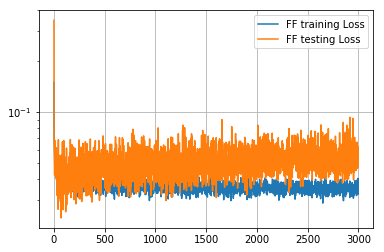

In [54]:
from matplotlib import pyplot
plt.plot(seq_history.history['loss'], label='FF training Loss')
plt.plot(seq_history.history['val_loss'], label='FF testing Loss')
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

In [21]:
# Generate predictions
raw_seq_predictions = pd.DataFrame(seq_model.predict(x_test),columns = ['seq_prediction'], index = test_index)

In [22]:
# Invert scaling for prediction data
x_test = pd.DataFrame(x_test, columns = x_columns, index = test_index)
unscaled_seq_predictions = pd.concat([x_test, raw_seq_predictions], axis=1)
#unscaled_seq_predictions = pd.concat([unscaled_seq_predictions, test_data.google_45d], axis=1)
unscaled_seq_predictions = pd.DataFrame(scaler.inverse_transform(unscaled_seq_predictions), columns=unscaled_seq_predictions.columns, index=unscaled_seq_predictions.index)

# Invert scaling for actual data
unscaled_data = pd.concat([x_test, y_test], axis=1)
#unscaled_data = pd.concat([unscaled_data, test_data.google_45d], axis=1)
unscaled_data = pd.DataFrame(scaler.inverse_transform(unscaled_data), columns=unscaled_data.columns, index=unscaled_data.index)
#unscaled_data = unscaled_data['google_45d_sta']

In [23]:
backup['unscaled_seq_predictions'] = unscaled_seq_predictions
backup['unscaled_data'] = unscaled_data

In [24]:
unscaled_seq_predictions.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_04,nasdaq_std_04,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,seq_prediction
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-31,1220.010010,1227.588013,1205.599976,1217.260010,1217.260010,1644700.0,1218.500000,1.753611,1237.301409,24.147664,...,7650.895020,29.550020,7786.610073,109.258547,7805.587565,85.060270,0.307801,0.089192,0.152314,1066.033145
2018-08-01,1228.000000,1233.469971,1210.209961,1220.010010,1220.010010,1567200.0,1219.003337,1.515790,1239.374268,21.433011,...,7669.693359,38.687654,7767.384347,109.753646,7798.026217,85.881161,0.285090,0.083101,0.146205,1069.279489
2018-08-02,1205.900024,1229.880005,1204.790039,1226.150024,1226.150024,1531300.0,1220.790009,3.781604,1236.241420,21.550840,...,7702.942505,73.619602,7761.944336,106.402575,7798.359340,82.521365,0.271257,0.086055,0.164864,1094.989721
2018-08-03,1229.619995,1230.000000,1215.060059,1223.709961,1223.709961,1089600.0,1221.782501,3.932133,1230.528564,18.079647,...,7748.444946,69.648419,7744.768555,81.003961,7798.808594,82.581619,0.214106,0.085981,0.165144,1093.122379
2018-08-06,1225.000000,1226.088013,1215.796997,1224.770020,1224.770020,1081700.0,1224.239991,0.749575,1221.940003,3.444802,...,7835.844971,33.708070,7747.243327,90.494779,7792.345052,87.849464,0.151643,0.065983,0.139857,1084.553800


In [25]:
unscaled_data.head()

,google_open,google_high,google_low,google_close,google,google_volume,google_ra_04,google_std_04,google_ra_09,google_std_09,...,nasdaq_ra_04,nasdaq_std_04,nasdaq_ra_09,nasdaq_std_09,nasdaq_ra_18,nasdaq_std_18,google_daily_vol,s&p_daily_vol,nasdaq_daily_vol,google_45d
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-31,1220.010010,1227.588013,1205.599976,1217.260010,1217.260010,1644700.0,1218.500000,1.753611,1237.301409,24.147664,...,7650.895020,29.550020,7786.610073,109.258547,7805.587565,85.060270,0.307801,0.089192,0.152314,1156.050049
2018-08-01,1228.000000,1233.469971,1210.209961,1220.010010,1220.010010,1567200.0,1219.003337,1.515790,1239.374268,21.433011,...,7669.693359,38.687654,7767.384347,109.753646,7798.026217,85.881161,0.285090,0.083101,0.146205,1161.219971
2018-08-02,1205.900024,1229.880005,1204.790039,1226.150024,1226.150024,1531300.0,1220.790009,3.781604,1236.241420,21.550840,...,7702.942505,73.619602,7761.944336,106.402575,7798.359340,82.521365,0.271257,0.086055,0.164864,1171.089966
2018-08-03,1229.619995,1230.000000,1215.060059,1223.709961,1223.709961,1089600.0,1221.782501,3.932133,1230.528564,18.079647,...,7748.444946,69.648419,7744.768555,81.003961,7798.808594,82.581619,0.214106,0.085981,0.165144,1186.869995
2018-08-06,1225.000000,1226.088013,1215.796997,1224.770020,1224.770020,1081700.0,1224.239991,0.749575,1221.940003,3.444802,...,7835.844971,33.708070,7747.243327,90.494779,7792.345052,87.849464,0.151643,0.065983,0.139857,1166.089966


In [26]:
seq_accuracy=np.sqrt(metrics.mean_squared_error(unscaled_data.google_45d, unscaled_seq_predictions.seq_prediction))

/home/matthias/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


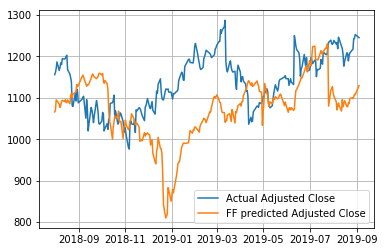

In [27]:
# Plot prediction vs actual
plt.plot(unscaled_data['google_45d'], label='Actual Adjusted Close')
plt.plot(unscaled_seq_predictions['seq_prediction'], label='FF predicted Adjusted Close')
plt.grid()
plt.legend()
plt.show()

### LSTM model

#### Split into train and test set
And here you have to be careful according to https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/ :

"A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input. In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer. By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function."

But in order to can use "stateful = True" the data has to be a multiple of the batch size. Therefore I have to use modulo to get the test size correctly.

In [ ]:
batch_size = 10
train_test_split = 0.9
x_train, x_test, y_train, y_test, test_data, test_index, x_columns = get_train_test_data(df_scaled, train_test_split, batch_size)

In [28]:
x_train=x_train.to_numpy()
y_train=y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()
# Reshape data for (Sample, Timesteps, Features)
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [29]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, input_shape = (x_train.shape[1], x_train.shape[2]), dropout = 0.2, return_sequences = True))
lstm_model.add(LSTM(units = 100, dropout = 0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer = 'adam', loss='mse')
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            56000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 136,501
Trainable params: 136,501
Non-trainable params: 0
_________________________________________________________________


In [30]:
start_lstm = time.time()
lstm_model.reset_states()
history=lstm_model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test));
end_lstm = time.time()
time_lstm = end_lstm - start_lstm
time_lstm

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2370 samples, validate on 270 samples
Epoch 1/100
2370/2370 [==============================] - 4s 2ms/step - loss: 0.0237 - val_loss: 0.0215
Epoch 2/100
2370/2370 [==============================] - 2s 976us/step - loss: 0.0088 - val_loss: 0.0169
Epoch 3/100
2370/2370 [==============================] - 2s 866us/step - loss: 0.0088 - val_loss: 0.0181
Epoch 4/100
2370/2370 [==============================] - 2s 1ms/step - loss: 0.0085 - val_loss: 0.0164
Epoch 5/100
2370/2370 [==============================] - 2s 944us/step - loss: 0.0076 - val_loss: 0.0159
Epoch 6/100
2370/2370 [==============================] - 2s 670us/step - loss: 0.0078 - val_loss: 0.0190
Epoch 7/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0071 - val_loss: 0.0390
Epoch 8/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0074 - val_loss: 0.0206
Epoch 9/100
2370/2370 [====

2370/2370 [==============================] - 2s 971us/step - loss: 0.0040 - val_loss: 0.0189
Epoch 76/100
2370/2370 [==============================] - 2s 920us/step - loss: 0.0040 - val_loss: 0.0185
Epoch 77/100
2370/2370 [==============================] - 2s 841us/step - loss: 0.0041 - val_loss: 0.0180
Epoch 78/100
2370/2370 [==============================] - 2s 877us/step - loss: 0.0042 - val_loss: 0.0179
Epoch 79/100
2370/2370 [==============================] - 2s 925us/step - loss: 0.0041 - val_loss: 0.0192
Epoch 80/100
2370/2370 [==============================] - 2s 913us/step - loss: 0.0041 - val_loss: 0.0182
Epoch 81/100
2370/2370 [==============================] - 2s 782us/step - loss: 0.0042 - val_loss: 0.0216
Epoch 82/100
2370/2370 [==============================] - 3s 1ms/step - loss: 0.0041 - val_loss: 0.0196
Epoch 83/100
2370/2370 [==============================] - 2s 893us/step - loss: 0.0040 - val_loss: 0.0301
Epoch 84/100
2370/2370 [==============================] - 3s 

208.05039978027344

In [31]:
lstm_model.evaluate(x_train, y_train, batch_size=batch_size)

2370/2370 [==============================] - 0s 117us/step


0.0039493569060341

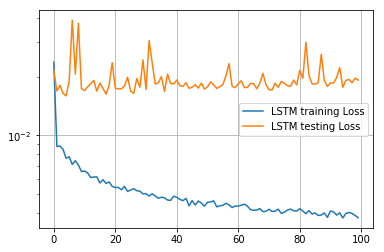

In [46]:
from matplotlib import pyplot
plt.plot(history.history['loss'], label='LSTM training Loss')
plt.plot(history.history['val_loss'], label='LSTM testing Loss')
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

#### Get predictions

In [34]:
# Generate predictions
raw_lstm_predictions = pd.DataFrame(lstm_model.predict(x_test, batch_size=batch_size),columns = ['lstm_prediction'], index = test_index)

#### Convert data

In [35]:
x_test = x_test.reshape(x_test.shape[0], x_test.shape[2]) # transform x_test back to 2D array
x_test = pd.DataFrame(x_test, columns = x_columns, index = test_index)
y_test = pd.DataFrame(y_test, columns = ['google_45d'], index = test_index)

In [36]:
# Invert scaling for prediction data
unscaled_lstm_predictions = pd.concat([x_test, raw_lstm_predictions], axis=1)
#unscaled_lstm_predictions = pd.concat([unscaled_lstm_predictions, test_data.google_45d], axis=1)
unscaled_lstm_predictions = pd.DataFrame(scaler.inverse_transform(unscaled_lstm_predictions), columns=unscaled_lstm_predictions.columns, index=unscaled_lstm_predictions.index)

# Invert scaling for actual data
test_data_unscaled = pd.concat([x_test, y_test], axis=1)
#test_data_unscaled = pd.concat([test_data_unscaled, test_data.google_45d], axis=1)
test_data_unscaled = pd.DataFrame(scaler.inverse_transform(test_data_unscaled), columns=test_data_unscaled.columns, index=test_data_unscaled.index)

In [37]:
backup['unscaled_lstm_predictions'] = unscaled_lstm_predictions
backup['test_data_unscaled'] = test_data_unscaled

In [38]:
lstm_accuracy=np.sqrt(metrics.mean_squared_error(unscaled_data.google_45d, unscaled_lstm_predictions.lstm_prediction))
print('Accuracy of feedforward model is {} \nAccuracy of LSTM model is        {}'.format(round(seq_accuracy,2), round(lstm_accuracy)))

Accuracy of feedforward model is 109.95 
Accuracy of LSTM model is        79.0


/home/matthias/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


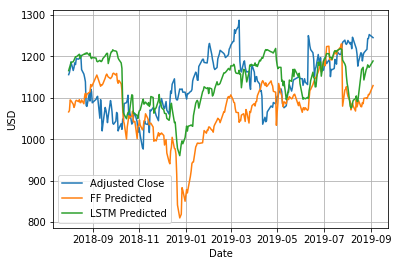

In [4]:
# Plot prediction vs actual
plt.plot(test_data_unscaled['google_45d'], label='Adjusted Close')
plt.plot(unscaled_seq_predictions['seq_prediction'], label='FF Predicted')
plt.plot(unscaled_lstm_predictions['lstm_prediction'], label='LSTM Predicted')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.legend()
plt.show()

In [41]:
print('Run time for feedforward model is {} seconds \nRun time for LSTM model is {} seconds'.format(time_seq,time_lstm))

Run time for feedforward model is 342.3582148551941 seconds 
Run time for LSTM model is 208.05039978027344 seconds


In [5]:
backup.close()